# Garbage image classification

## 1. Cleaning images

Listing the images folders

In [1]:
import os

images_folder = "./garbage-images"

#Read the folders where we have the images - these folders represent our classes
def list_folders_in_directory(directory):
    folders = [folder for folder in os.listdir(directory) if os.path.isdir(os.path.join(directory, folder))]
    return folders

folders_list = list_folders_in_directory(images_folder)
print(folders_list)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


### Selecting only allowed image formats

In [2]:
import cv2
import imghdr

allowed_formats = ['jpeg','jpg', 'bmp', 'png']

def remove_images_in_unnacepted_format(images_folder, allowed_formats):
    for image_class in os.listdir(images_folder):
        for image in os.listdir(os.path.join(images_folder, image_class)):
            image_path = os.path.join(images_folder, image_class, image)
            try: 
                tip = imghdr.what(image_path)
                if tip not in allowed_formats: 
                    print('Image not in ext list {}'.format(image_path))
                    os.remove(image_path)
            except Exception as e: 
                print('Issue with image {}'.format(image_path))

remove_images_in_unnacepted_format(images_folder, allowed_formats)

Rename all images so the are in the proper format: {folder-name}-{number}

In [3]:
import pathlib

def rename_images(images_folder) -> None:
    for image_class in os.listdir(images_folder):
        max_counter = len(os.listdir(os.path.join(images_folder, image_class)))
        zfill_num = len(str(max_counter))  # Calculate the number of digits required
        counter = 1  

        for image in os.listdir(os.path.join(images_folder, image_class)):
            image_path = os.path.join(images_folder, image_class, image)
            try: 
                extension = pathlib.Path(image).suffix
                expected_name = f"{image_class}-{str(counter).zfill(zfill_num)}{extension}"  # Dynamically set zfill number
                
                if image != expected_name:
                    new_image_name = f"{image_class}-{str(counter).zfill(zfill_num)}{extension}"
                    new_image_path = os.path.join(images_folder, image_class, new_image_name)
                    os.rename(image_path, new_image_path)
                    print(f"Renamed '{image}' to '{new_image_name}'")
                counter += 1 
            except Exception as e: 
                print('Issue with image {}'.format(image_path))

rename_images(images_folder)

### Removing images that are too small or too lare

In [4]:
def remove_images_out_of_size_range(images_folder, min_size_bytes, max_size_bytes):
    for image_class in os.listdir(images_folder): 
        for image in os.listdir(os.path.join(images_folder, image_class)):
            image_path = os.path.join(images_folder, image_class, image)
            if os.path.isfile(image_path):
                try: 
                    size_bytes = os.path.getsize(image_path)
                    size_kb = size_bytes / 1024
                    if not (min_size_bytes <= size_bytes <= max_size_bytes):
                        os.remove(image_path)
                        print(f"Removed {image} - Size: {size_kb} KB ({size_bytes} bytes)")
                except Exception as e: 
                    print('Issue with image {}'.format(image_path))


# Define your folder path and size range
min_size_bytes = 5 * 1024  # 5 KB
max_size_bytes = 1 * 1024 * 1024  # 1 MB

remove_images_out_of_size_range(images_folder, min_size_bytes, max_size_bytes)

## 2. Create the dataset

We bring our folder images and we create a data frame.

In [5]:
import pandas as pd
import numpy as np

data = []
for folder in folders_list: 
    files = os.listdir(os.path.join(images_folder, folder))
    #Add each file along with its folder name to the data list
    for file in files:
        data.append({'Folder': folder, 'File_Name': file})

# Create a DataFrame from the data list
df = pd.DataFrame(data)

# Display the DataFrame
df.head()

,Folder,File_Name
0,cardboard,cardboard-001.jpg
1,cardboard,cardboard-002.jpg
2,cardboard,cardboard-003.jpg
3,cardboard,cardboard-004.jpg
4,cardboard,cardboard-005.jpg


## 3. Analising the data

First we are checking our data set to see how manny photos we have.

In [6]:
df.shape

(2527, 2)

We want to check how manny images we have in each category.

In [7]:
df['Folder'].value_counts()

Folder
paper        594
glass        501
plastic      482
metal        410
cardboard    403
trash        137
Name: count, dtype: int64

We have some inbalance data in 'trash'

We want to see what file format we have in the dataset.

We can see that we have only 'jpg' files.

In [8]:
# Extract extension using str.split and str.get
df['Extension'] = df['File_Name'].str.split('.').str[-1]
df['Extension'].value_counts()

Extension
jpg    2527
Name: count, dtype: int64

We want to check the dimension of images.

We are adding the dimensions of the image into the dataframe with the help of Pillow library

In [9]:
from PIL import Image

def get_image_dimensions(df_row):
    file_path = os.path.join(images_folder, df_row['Folder'], df_row['File_Name'])
    image = Image.open(file_path)
    width, height = image.size
    return width, height

df['Image_width'], df['Image_height'] = zip(*df.apply(get_image_dimensions, axis=1))

df.head()

,Folder,File_Name,Extension,Image_width,Image_height
0,cardboard,cardboard-001.jpg,jpg,512,384
1,cardboard,cardboard-002.jpg,jpg,512,384
2,cardboard,cardboard-003.jpg,jpg,512,384
3,cardboard,cardboard-004.jpg,jpg,512,384
4,cardboard,cardboard-005.jpg,jpg,512,384


We are checking how many different values we are having in those two columns.

It seems that all the files have the same size. This means that we do not need to do any transformation to the size of the files.

In [10]:
print(df.Image_width.value_counts())
print(30*'*')
print(df.Image_height.value_counts())

Image_width
512    2527
Name: count, dtype: int64
******************************
Image_height
384    2527
Name: count, dtype: int64


## 4. Loading the data

We need to load the data to normalise it, and split the data in training dataset and validation dataset.

I need to load the images based on the dataframe that I created and the images that I have in those class folders. I need to load this images into batches and I need to create a ImagePipeline from tensorflow. This will make things load smoother than If I would load everything in one go

In [11]:
import numpy as np
import tensorflow as tf


batch_size = 32
img_height = 256
img_width = 256
seed_value = 42

#the labels for the classes we have
label_mapping = {
    'cardboard': 0,
    'glass': 1,
    'metal': 2,
    'paper': 3,
    'plastic': 4,
    'trash': 5
}

data = tf.keras.utils.image_dataset_from_directory(
    images_folder,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=seed_value,
    labels="inferred",
    label_mode="int",
    class_names=list(label_mapping.keys()))
    
data_iterator = data.as_numpy_iterator()

# Print the class names and their corresponding integer labels
for label, class_name in enumerate(data.class_names):
    print(f"Class Name: {class_name}, Label: {label}")

Found 2527 files belonging to 6 classes.
Class Name: cardboard, Label: 0
Class Name: glass, Label: 1
Class Name: metal, Label: 2
Class Name: paper, Label: 3
Class Name: plastic, Label: 4
Class Name: trash, Label: 5


Images respresented as numpy arrays

We can get a batch of data using the iterator

In [12]:
batch = data_iterator.next()

Show the shape of the batch

In [13]:
batch[0].shape

(32, 256, 256, 3)

Check the labels in the tensors batch

In [14]:
batch[1]

array([1, 4, 1, 2, 4, 2, 0, 4, 4, 3, 2, 3, 1, 2, 0, 0, 3, 0, 2, 0, 2, 3,
       2, 0, 3, 1, 4, 2, 1, 3, 4, 0])

Check the shape of the batch

In [15]:
for image_batch, labels_batch in data:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


In [16]:
class_names = data.class_names
print(class_names)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


Display image before resizing it - the initial image

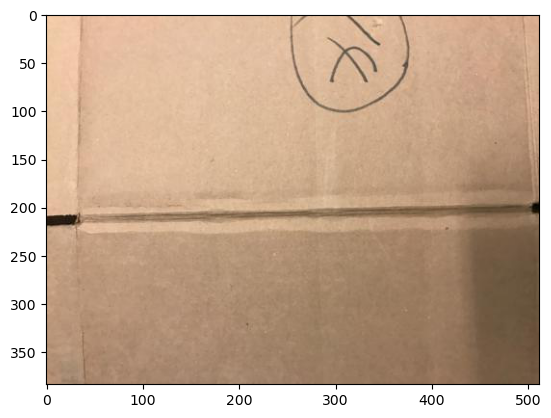

In [17]:
from matplotlib import pyplot as plt

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

def show_image(image_class, image):
    img = cv2.imread(os.path.join(images_folder, image_class,  image))
    im_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(im_rgb)
    plt.show()

show_image('cardboard','cardboard-001.jpg')

Another way of showing an image

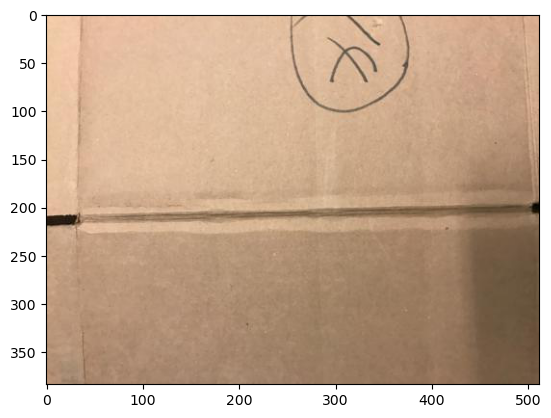

In [20]:
img = cv2.imread(os.path.join(images_folder, 'cardboard', 'cardboard-001.jpg'))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

Now let's see how that first image would look resized in the batch:

Load first 4 images from first batch to see how they look after resizing

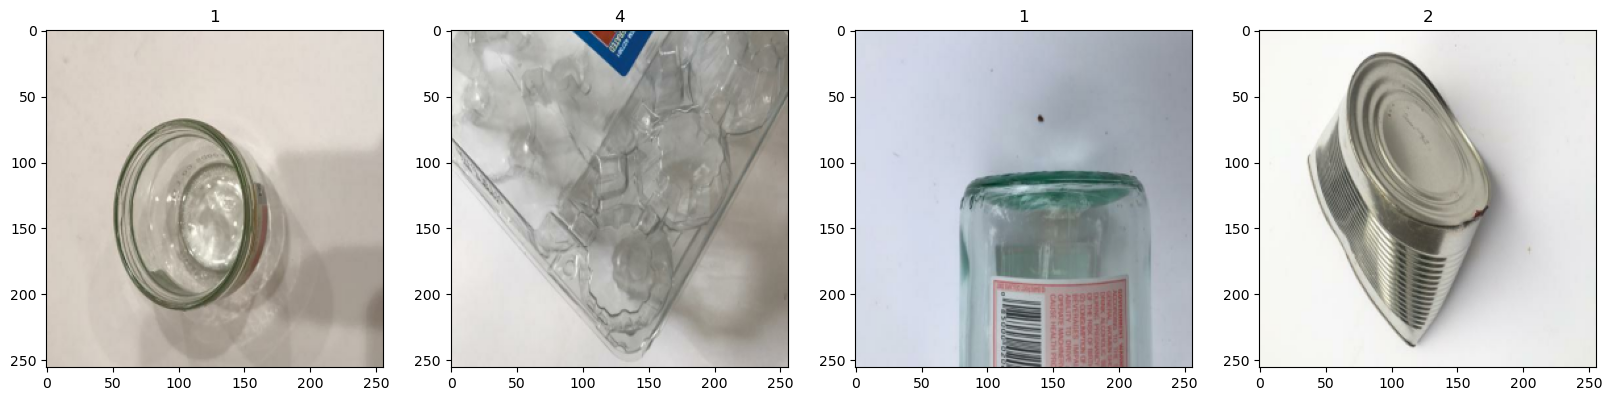

In [21]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

### Configure the performance of the dataset

Configure the dataset for performance
Make sure to use buffered prefetching, so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

Dataset.cache keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
Dataset.prefetch overlaps data preprocessing and model execution while training.

In [22]:
AUTOTUNE = tf.data.AUTOTUNE
data = data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

## 5. Preprocess Data

### Augment the data

I will create a layer where I will augment the data by flipping the picures, rotate them, zoom them, etc to create more representations of the same image from different angles and persepctives. This extra layer will help the model

In [23]:
from tensorflow import keras
from keras import layers
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

Let's see the augmented images

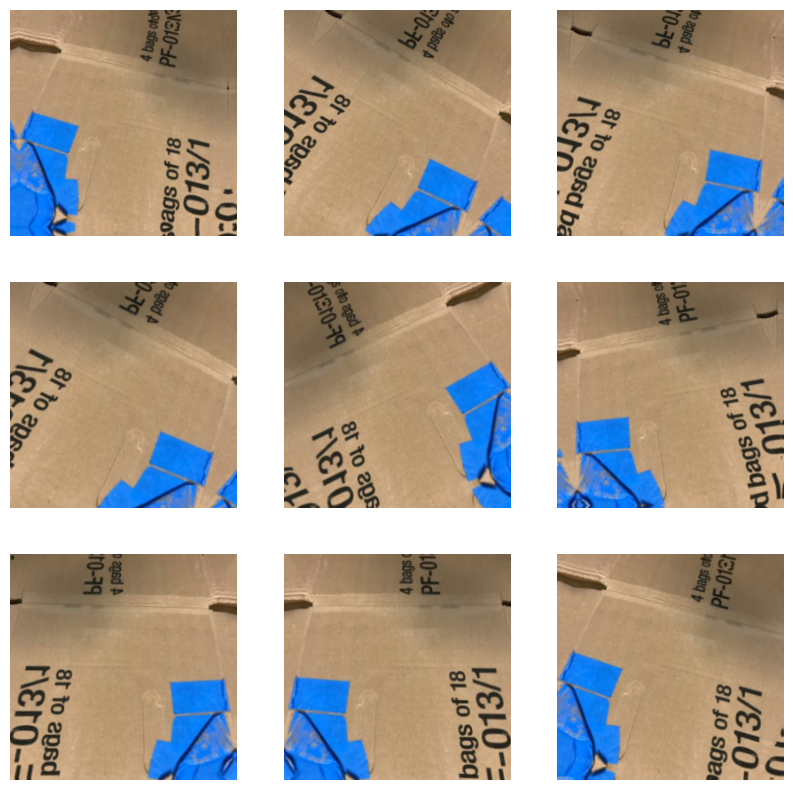

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, _ in data.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

plt.show()

### Scale the data

The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the [0, 1] 

In [25]:
#normalization_layer = tf.keras.layers.Rescaling(1./255)
#normalized_ds = data.map(lambda x, y: (normalization_layer(x), y))

data = data.map(lambda x, y: (x/255, y))
scaled_iterator = data.as_numpy_iterator()

In [26]:
batch = scaled_iterator.next()
batch[0].max()

1.0

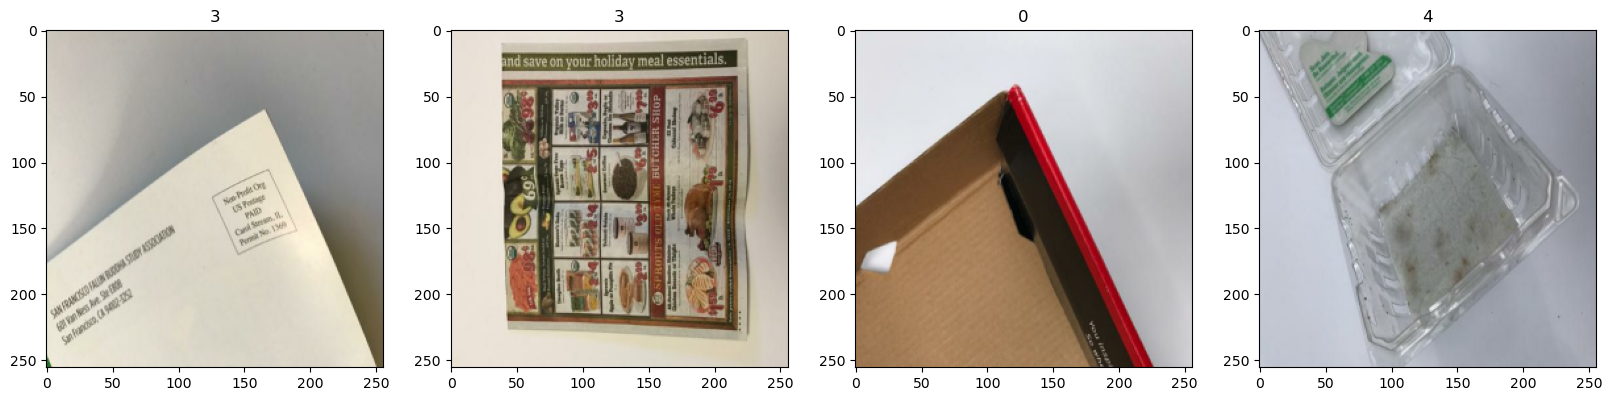

In [27]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

### Split the data

I need a trainig dataset, a validation and a  testing or predictions dataset

In [28]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

print("Train images: ", train_size)
print("Validation images: ", val_size)
print("Testing/Prediction images: ", test_size)

Train images:  55
Validation images:  15
Testing/Prediction images:  7


In [29]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

## 6. Building the Model

We defined the model architecture, here we have the conv and pooling layers.


In the first conv layer we define the inptut layer that has the shape of the image (width, height, channels). Than I have a few conv and poling layers and after the flatten layer that converts the data from the multi dimensional arrays(tensors) to an array and than feeds it to a feed forward network in the dense layer and than we have the outut layer with the number of neurons equal to the number of disticnt classes

In [30]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten


num_classes = len(class_names)

model_architecture = [
  Conv2D(16, (3,3), padding='same', activation='relu', input_shape=(img_height, img_width, 3)),
  MaxPooling2D(),
  Conv2D(32, (3,3), padding='same', activation='relu'),
  MaxPooling2D(),
  Conv2D(64, (3,3), padding='same', activation='relu'),
  MaxPooling2D(),
  Flatten(),
  Dense(128, activation='relu'),
  Dense(num_classes)
]

model = Sequential(model_architecture)

Compile the model

In [31]:
model.compile(optimizer='adam', loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [32]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 64)      

## Training the model

Define a few callback functions

In [33]:
import os
import shutil

logdir = 'logs'

# Clean logs data before running training
if os.path.exists(logdir):
    shutil.rmtree(logdir)

logger_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

# monitor the training loss and stop training if the loss doesn't improve for 3 consecutive epochs
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3) 

Training phase

In [34]:
epochs = 30
history = model.fit(train, epochs=epochs, validation_data=val, callbacks=[logger_callback, early_stopping_callback])

Epoch 1/30


55/55 [==============================] - 24s 408ms/step - loss: 1.9055 - accuracy: 0.2774 - val_loss: 1.5064 - val_accuracy: 0.3500
Epoch 2/30
55/55 [==============================] - 22s 402ms/step - loss: 1.3988 - accuracy: 0.4335 - val_loss: 1.2226 - val_accuracy: 0.5042
Epoch 3/30
55/55 [==============================] - 22s 403ms/step - loss: 1.2077 - accuracy: 0.5196 - val_loss: 1.2465 - val_accuracy: 0.5354
Epoch 4/30
55/55 [==============================] - 23s 414ms/step - loss: 1.0686 - accuracy: 0.5975 - val_loss: 1.0604 - val_accuracy: 0.5979
Epoch 5/30
55/55 [==============================] - 22s 408ms/step - loss: 0.9140 - accuracy: 0.6705 - val_loss: 0.8187 - val_accuracy: 0.7119
Epoch 6/30
55/55 [==============================] - 23s 410ms/step - loss: 0.8313 - accuracy: 0.7163 - val_loss: 0.7446 - val_accuracy: 0.7354
Epoch 7/30
55/55 [==============================] - 23s 416ms/step - loss: 0.7129 - accuracy: 0.7544 - val_loss: 0.5987 - val_accuracy: 0.8100
Epoch 8/30

### Plot performance

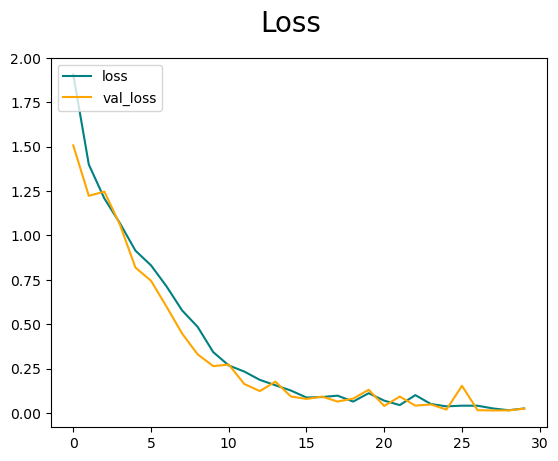

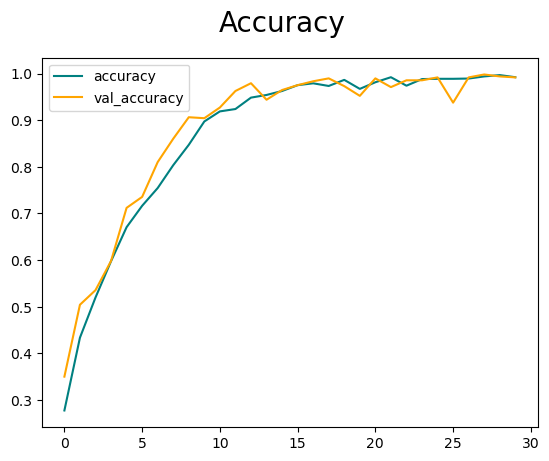

In [35]:
import matplotlib.pyplot as plt

history_metrics = history.history


def plot_metrics(history, metric):
    if metric not in history:
        raise ValueError(f"{metric} not found in history. Available metrics: {', '.join(history.keys())}")
    
    fig = plt.figure()
    plt.plot(history[metric], color='teal', label=metric)
    val_metric = 'val_' + metric
    plt.plot(history[val_metric], color='orange', label=val_metric)
    fig.suptitle(metric.capitalize(), fontsize=20)
    plt.legend(loc="upper left")
    plt.show()

plot_metrics(history_metrics, metric='loss')
plot_metrics(history_metrics, metric='accuracy') 


## Evaluate performance

Add Softmax layer to convert from logits ouput to probabilities

In [36]:
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])

Evaluate the perfromance for one image

In [37]:
from keras.metrics import Precision, Recall, Accuracy

precision = Precision()
recall = Recall()
accuracy = Accuracy()

#Get first batch from test dataset
first_batch = next(iter(test.as_numpy_iterator()))

# Extract the first image and its label
X_first, y_first = first_batch[0][0], first_batch[1][0]

#Ensure the shape of X_first is suitable for prediction
X_first = np.expand_dims(X_first, axis=0)

# Predict the probabilities for the first image
yhat_first = probability_model.predict(X_first)

# Convert the label to one-hot encoding
y_one_hot = tf.one_hot(y_first, depth=num_classes)  

# Obtain the predicted class label (the class with the highest probability)
predicted_class = np.argmax(yhat_first)

# Convert the label to one-hot encoding
predicted_one_hot = tf.one_hot(predicted_class, depth=num_classes)

print("Predicted class ", predicted_class)
print("Predicted class ", y_first)
print("Y one hot: ", y_one_hot)
print("Predicted class: ", predicted_class)

# Update metrics
precision.update_state(y_one_hot, predicted_one_hot)
recall.update_state(y_one_hot, predicted_one_hot)
accuracy.update_state(y_one_hot, predicted_one_hot)

print(f'Precision: {precision.result().numpy()}, Recall: {recall.result().numpy()}, Accuracy: {accuracy.result().numpy()}')

1/1 [==============================] - 0s 204ms/step
Predicted class  1
Predicted class  1
Y one hot:  tf.Tensor([0. 1. 0. 0. 0. 0.], shape=(6,), dtype=float32)
Predicted class:  1
Precision: 1.0, Recall: 1.0, Accuracy: 1.0


Evaluate perfromance for all the testing images set

In [38]:
from keras.metrics import Precision, Recall, Accuracy
from sklearn.metrics import f1_score, classification_report

precision = Precision()
recall = Recall()
accuracy = Accuracy()

# Lists to store true and predicted labels for F1-score calculation
true_labels = []
predicted_labels = []

for batch in test.as_numpy_iterator():
    X, y = batch 
    yhat = probability_model.predict(X)

    # Convert the label to one-hot encoding
    y_one_hot = tf.one_hot(y, depth=num_classes)

    # Obtain the predicted class labels (the classes with the highest probability for each sample)
    predicted_class = np.argmax(yhat, axis=1)
    
    # Convert the label to one-hot encoding
    predicted_one_hot = tf.one_hot(predicted_class, depth=num_classes)
    
    precision.update_state(y_one_hot, predicted_one_hot)
    recall.update_state(y_one_hot, predicted_one_hot)
    accuracy.update_state(y_one_hot, predicted_one_hot)

    true_labels.extend(y)
    predicted_labels.extend(predicted_class)

# Compute F1-score
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print(f'Precision: {precision.result().numpy()}, Recall: {recall.result().numpy()}, Accuracy: {accuracy.result().numpy()}, F1-score: {f1}')

# Optionally, you can print the classification report for more detailed information
report = classification_report(true_labels, predicted_labels)
print("Classification Report:\n", report)

1/1 [==============================] - 0s 106ms/step
Precision: 0.9866071343421936, Recall: 0.9866071343421936, Accuracy: 0.9955357313156128, F1-score: 0.9866123318757957
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       1.00      1.00      1.00        56
           2       1.00      1.00      1.00        29
           3       1.00      0.93      0.97        46
           4       0.93      1.00      0.97        42
           5       1.00      1.00      1.00        14

    accuracy                           0.99       224
   macro avg       0.99      0.99      0.99       224
weighted avg       0.99      0.99      0.99       224



Confusion Matrix

Confusion Matrix:
[[37  0  0  0  0  0]
 [ 0 56  0  0  0  0]
 [ 0  0 29  0  0  0]
 [ 0  0  0 43  3  0]
 [ 0  0  0  0 42  0]
 [ 0  0  0  0  0 14]]


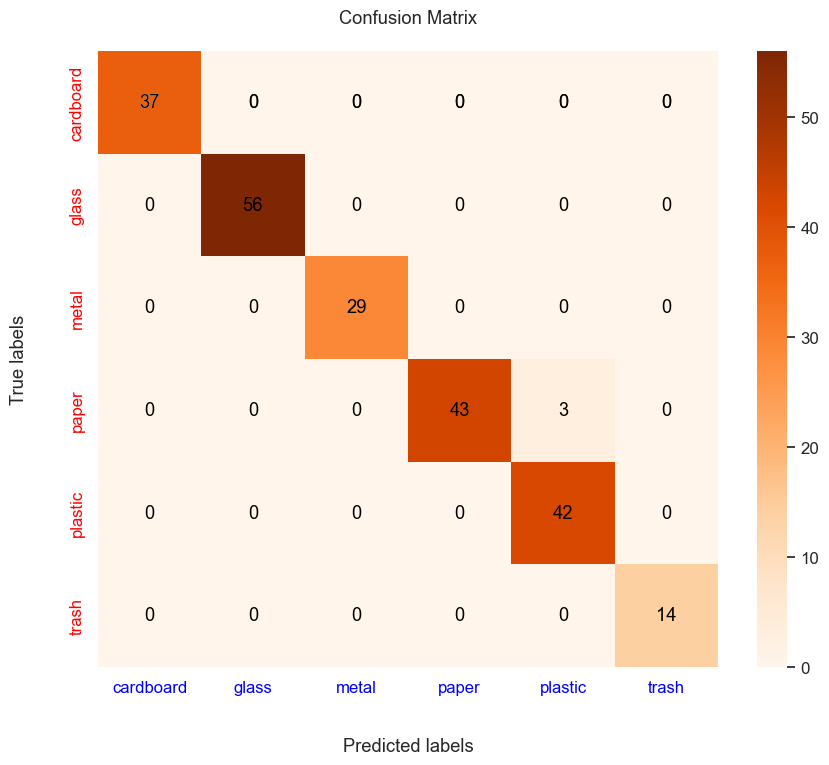

In [39]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.set(font_scale = 1.1)

heatmap  = sns.heatmap(cm, annot=True, cmap='Oranges', fmt='d', xticklabels=class_names, yticklabels=class_names)

for (i, j), val in np.ndenumerate(cm):
    plt.text(j+0.5, i+0.5, val, ha='center', va='center', color='black')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Set x and y ticks label colors
plt.tick_params(axis='x', colors='blue')
plt.tick_params(axis='y', colors='red')

# Set x and y labels
xlabel = plt.xlabel('Predicted labels', labelpad=30)
ylabel = plt.ylabel('True labels', labelpad=30)

# Set the title and adjust its position
title = plt.title('Confusion Matrix', pad=20)
title.set_position([.5, 1.03])

plt.show()

## Save the model

We save the model so we use it wheneaver we want.

In [40]:
model.save(os.path.join('models', 'trash-classification-model.h5'))

Load the model

In [31]:
from keras.models import load_model
saved_model = load_model(os.path.join('models', 'trash-classification-model.h5'))
saved_model_probability = tf.keras.Sequential([saved_model, tf.keras.layers.Softmax()])

## Make predictions on new data

Predict on new data

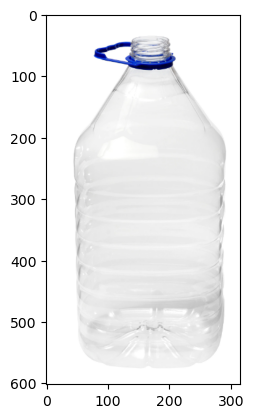

In [32]:
import cv2

def get_image(image_path):
    img = cv2.imread(image_path)
    im_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return im_rgb

unseen_images_folder = "unseen-images"

new_image = get_image(os.path.join(unseen_images_folder, "plastic-bottle-1.png"))
plt.imshow(new_image)
plt.show()

Resize the image

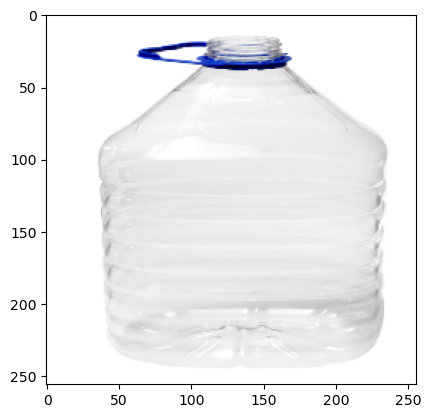

In [33]:
def resize_image(image, height, width):
    return tf.image.resize(image, (height, width))

resized_image = resize_image(new_image, img_height, img_width) # resize the image to 256x256
plt.imshow(resized_image.numpy().astype(int))
plt.show()

Predict on the new image

In [34]:
expected_label = label_mapping['plastic']

new_prediction = saved_model_probability.predict(np.expand_dims(resized_image/255, axis=0))
new_predicted_class = np.argmax(new_prediction)

print("Expected label: ", expected_label)
print("Predicted label: ", new_predicted_class)

1/1 [==============================] - 0s 181ms/step
Expected label:  4
Predicted label:  4
